# **Dataset preprocessing**

In [ ]:
import os

# Create YoloV8 Folder
os.makedirs("/content/YoloV8", exist_ok=True)

Upload dataset (.tar or zip) file to YoloV8 Folder

Extract archived data

In [ ]:
!tar -xvzf /content/YoloV8/idd-lite.tar.gz -C /content/YoloV8/

Streaming output truncated to the last 5000 lines.
idd20k_lite/gtFine/train/371/
idd20k_lite/gtFine/train/371/frame18444_label.png
idd20k_lite/gtFine/train/371/frame19399_label.png
idd20k_lite/gtFine/train/371/frame12335_label.png
idd20k_lite/gtFine/train/371/frame18444_inst_label.png
idd20k_lite/gtFine/train/371/frame12335_inst_label.png
idd20k_lite/gtFine/train/371/frame19399_inst_label.png
idd20k_lite/gtFine/train/316/
idd20k_lite/gtFine/train/316/frame12094_label.png
idd20k_lite/gtFine/train/316/frame23904_inst_label.png
idd20k_lite/gtFine/train/316/frame11820_label.png
idd20k_lite/gtFine/train/316/frame12094_inst_label.png
idd20k_lite/gtFine/train/316/frame3750_inst_label.png
idd20k_lite/gtFine/train/316/frame20123_label.png
idd20k_lite/gtFine/train/316/frame20123_inst_label.png
idd20k_lite/gtFine/train/316/frame11820_inst_label.png
idd20k_lite/gtFine/train/316/frame3750_label.png
idd20k_lite/gtFine/train/316/frame23904_label.png
idd20k_lite/gtFine/train/170/
idd20k_lite/gtFine/tr

# **YOLO labeling format . txt file creation from segementaion files**

Code to convert label file in txt format and copy the .txt file into same directory as image file

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def get_bounding_boxes_by_class(mask, min_area_threshold=10):
    """
    Extract bounding boxes from a segmentation mask for each unique class ID.
    """
    bounding_boxes = []
    unique_classes = np.unique(mask)  # Get unique pixel values (class IDs)

    for class_id in unique_classes:
        if class_id != 2:  # Class Id 2 is for "Person"
            continue

        # Create a binary mask for the current class
        class_mask = (mask == class_id).astype(np.uint8)

        # Find contours for the current class
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Extract bounding boxes for the current class
        for contour in contours:
            if cv2.contourArea(contour) < min_area_threshold:  # Filter small regions
                continue
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append([class_id, x, y, x + w, y + h])  # Include class_id with bbox

    return bounding_boxes

def convert_to_yolo_format(image_width, image_height, xmin, ymin, xmax, ymax, class_id):
    """
    Convert bounding box coordinates to YOLO format.
    """
    x_center = ((xmin + xmax) / 2) / image_width
    y_center = ((ymin + ymax) / 2) / image_height
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def convert_segmentation_to_yolo_multiclass(image_path, mask_path, output_txt_path):
    """
    Convert segmentation mask to YOLO format annotations for multiple classes.
    """
    # Load image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale mask

    if image is None or mask is None:
        raise ValueError(f"Could not load image or mask: {image_path}, {mask_path}")

    image_height, image_width = image.shape[:2]

    # Validate dimensions
    assert mask.shape == (image_height, image_width), "Image and mask dimensions do not match."

    # Get bounding boxes by class
    bounding_boxes = get_bounding_boxes_by_class(mask)

    # Write YOLO format annotations to text file
    with open(output_txt_path, 'w') as f:
        for (class_id, xmin, ymin, xmax, ymax) in bounding_boxes:
            yolo_format = convert_to_yolo_format(image_width, image_height, xmin, ymin, xmax, ymax, class_id)
            f.write(yolo_format + '\n')

def process_images_and_masks(image_folder, mask_folder):
    """
    Process all images and corresponding masks to generate YOLO format annotations.
    """
    successful_count = 0
    unsuccessful_count = 0

    # Walk through the image folder and process each image
    for subdir, _, files in os.walk(image_folder):
        for file in tqdm(files, desc="Processing images"):
            if file.endswith('.jpg') or file.endswith('.png'):  # Check for image files
                image_path = os.path.join(subdir, file)

                # Generate corresponding mask path based on relative subdirectory structure
                relative_path = os.path.relpath(subdir, image_folder)  # Get relative subdirectory path
                base_filename = os.path.splitext(file)[0]  # Get base filename (without extension)

                # Construct mask filename and path
                mask_filename = base_filename.replace('_image', '') + '_label.png'
                mask_path = os.path.join(mask_folder, relative_path, mask_filename)

                if os.path.exists(mask_path):
                    # Save the YOLO annotation in the same folder as the image
                    output_txt_path = os.path.join(subdir, file.replace('.jpg', '.txt').replace('.png', '.txt'))

                    try:
                        # Convert the segmentation to YOLO format
                        convert_segmentation_to_yolo_multiclass(image_path, mask_path, output_txt_path)
                        successful_count += 1
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")
                else:
                    print(f"Mask not found for: {image_path}")
                    unsuccessful_count += 1

    print(f"\nTotal successful mask generations: {successful_count}")
    print(f"Total unsuccessful mask generations: {unsuccessful_count}")
    return successful_count, unsuccessful_count

# Example usage
image_folder = r"/content/YoloV8/idd20k_lite/leftImg8bit"
mask_folder = r"/content/YoloV8/idd20k_lite/gtFine"

successful_count, unsuccessful_count = process_images_and_masks(image_folder, mask_folder)

Processing images: 0it [00:00, ?it/s]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 1/1 [00:00<00:00, 372.40it/s]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 1/1 [00:00<00:00, 347.96it/s]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 9/9 [00:00<00:00, 24369.75it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/362800_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/490700_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/424942_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/825633_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/284984_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/292016_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/285412_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/034562_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/27/624644_image.jpg


Processing images: 100%|██████████| 16/16 [00:00<00:00, 26546.23it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame59380_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame32762_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame4989_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame11708_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame50217_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame47053_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame9429_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame27417_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame49453_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame10071_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/271/frame28071_image.jpg
Mask not fou

Processing images: 100%|██████████| 6/6 [00:00<00:00, 23585.59it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/4/803513_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/4/428977_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/4/561373_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/4/348731_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/4/885911_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/4/262322_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 9892.23it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/552/frame0659_image.jpg


Processing images: 100%|██████████| 6/6 [00:00<00:00, 19538.68it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/109/004065_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/109/016532_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/109/026122_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/109/018066_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/109/014818_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/109/005571_image.jpg


Processing images: 100%|██████████| 14/14 [00:00<00:00, 26630.50it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/087915_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/459109_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/524627_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/737163_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/206349_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/669336_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/689896_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/705313_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/173697_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/168638_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/15/233193_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/

Processing images: 100%|██████████| 8/8 [00:00<00:00, 22795.13it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/572/frame96503_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/572/frame107656_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/572/frame87967_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/572/frame47030_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/572/frame41858_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/572/frame76567_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/572/frame94594_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/572/frame87358_image.jpg


Processing images: 100%|██████████| 6/6 [00:00<00:00, 23541.46it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/113/013879_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/113/003900_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/113/016879_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/113/010579_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/113/012679_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/113/015679_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 12945.38it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/253/frame2771_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/253/frame4961_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8793.09it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/559/0010526_image.jpg


Processing images: 100%|██████████| 3/3 [00:00<00:00, 17949.95it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/450/frame13799_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/450/frame7803_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/450/frame2553_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 17848.10it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/510/frame0719_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/510/frame36185_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/510/frame6609_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/510/frame45499_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 23399.19it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/427/frame45003_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/427/frame54249_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/427/frame23885_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/427/frame38867_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 20893.17it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/97/300873_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/97/066445_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/97/321568_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/97/456933_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 13797.05it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/500/frame0227_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/500/frame2129_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 9238.56it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/335/frame2849_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 12576.62it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/485/frame14262_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/485/frame46917_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 7231.56it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/200/frame1513_image.jpg


Processing images: 100%|██████████| 8/8 [00:00<00:00, 25950.84it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/531/0002893_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/531/0000961_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/531/0009870_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/531/0004301_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/531/0001996_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/531/0013147_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/531/0011572_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/531/0007467_image.jpg


Processing images: 100%|██████████| 7/7 [00:00<00:00, 21877.89it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/408/0011306_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/408/0012143_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/408/0008511_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/408/0002221_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/408/0009871_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/408/0008974_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/408/0010550_image.jpg


Processing images: 100%|██████████| 11/11 [00:00<00:00, 4406.62it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0026172_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0015623_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0030390_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0025912_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0000451_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0019936_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0028344_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0020590_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0018467_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0017854_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/480/0023863_image.jpg


Processing images: 100%|██████████| 3/3 [00:00<00:00, 16215.09it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/381/frame4230_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/381/frame14380_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/381/frame4800_image.jpg


Processing images: 100%|██████████| 5/5 [00:00<00:00, 20301.57it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/55/146301_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/55/118122_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/55/263138_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/55/689645_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/55/149395_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 7332.70it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/565/frame0359_image.jpg


Processing images: 100%|██████████| 5/5 [00:00<00:00, 20620.96it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/179/760057_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/179/594679_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/179/884940_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/179/346485_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/179/956796_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 466.29it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/180/162751_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8559.80it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/332/frame3419_image.jpg


Processing images: 100%|██████████| 13/13 [00:00<00:00, 26572.10it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame27117_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame32299_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame16617_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame15226_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame35080_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame17871_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame1419_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame32680_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame11408_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame3585_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/343/frame27880_image.jpg
Mask not fou

Processing images: 100%|██████████| 1/1 [00:00<00:00, 9218.25it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/425/frame5618_image.jpg


Processing images: 100%|██████████| 3/3 [00:00<00:00, 16215.09it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/74/198202_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/74/342614_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/74/408258_image.jpg


Processing images: 100%|██████████| 3/3 [00:00<00:00, 15439.16it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/129/011338_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/129/023938_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/129/019348_image.jpg


Processing images: 100%|██████████| 7/7 [00:00<00:00, 22602.10it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/103/981216_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/103/206393_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/103/665169_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/103/331011_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/103/416301_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/103/478626_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/103/881873_image.jpg


Processing images: 100%|██████████| 3/3 [00:00<00:00, 15015.41it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/114/347720_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/114/817367_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/114/795239_image.jpg


Processing images: 100%|██████████| 6/6 [00:00<00:00, 23741.34it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/19/171279_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/19/894649_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/19/090189_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/19/439348_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/19/523513_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/19/762865_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 7463.17it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/304/frame0864_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 17225.07it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/386/frame14380_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/386/frame12444_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/386/frame13999_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/386/frame10017_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 19195.90it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/58/626612_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/58/217129_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/58/628577_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/58/032828_image.jpg


Processing images: 100%|██████████| 7/7 [00:00<00:00, 23136.43it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/99/027100_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/99/016525_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/99/007976_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/99/004376_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/99/023200_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/99/000998_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/99/000300_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8665.92it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/229/frame5088_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 16561.91it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/366/frame25585_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/366/frame22024_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/366/frame27350_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/366/frame20268_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 11570.49it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/463/0004779_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/463/0001861_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 7943.76it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/256/frame1628_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8559.80it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/345/frame0469_image.jpg


Processing images: 100%|██████████| 16/16 [00:00<00:00, 26567.25it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/634537_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/561264_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/748780_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/500867_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/004475_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/495782_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/721186_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/703979_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/505327_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/493615_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/973487_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/8/829317_im

Processing images: 100%|██████████| 3/3 [00:00<00:00, 16754.88it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/165/628302_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/165/663015_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/165/555079_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 13148.29it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/123/294914_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/123/954693_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 7307.15it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/344/frame0899_image.jpg


Processing images: 100%|██████████| 7/7 [00:00<00:00, 19945.74it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/33/014488_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/33/003900_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/33/023779_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/33/011700_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/33/026343_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/33/020717_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/33/017188_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 9362.29it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/249/frame0014_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8422.30it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/159/627463_image.jpg


Processing images: 100%|██████████| 9/9 [00:00<00:00, 23637.28it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame6355_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame8725_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame19788_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame31242_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame31944_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame20422_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame18077_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame35599_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/324/frame17462_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8774.69it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/228/frame15171_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 9362.29it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/365/frame0003_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 9020.01it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/451/0004703_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 18641.35it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/232/frame12412_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/232/frame43678_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/232/frame16220_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/232/frame3532_image.jpg


Processing images: 100%|██████████| 7/7 [00:00<00:00, 22759.79it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/35/213995_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/35/105697_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/35/604204_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/35/674045_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/35/493025_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/35/597378_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/35/495106_image.jpg



Processing images: 100%|██████████| 5/5 [00:00<00:00, 19275.29it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/549/frame21335_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/549/frame1009_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/549/frame21526_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/549/frame10262_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/549/frame1929_image.jpg


Processing images: 100%|██████████| 3/3 [00:00<00:00, 16049.63it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/14/964050_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/14/829567_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/14/983201_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8962.19it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/576/0000925_image.jpg


Processing images: 100%|██████████| 7/7 [00:00<00:00, 22242.52it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/545/frame3783_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/545/frame12794_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/545/frame2108_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/545/frame0949_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/545/frame9833_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/545/frame12158_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/545/frame4517_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/111/000502_image.jpg


Processing images: 100%|██████████| 5/5 [00:00<00:00, 18995.94it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/208/frame6247_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/208/frame4646_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/208/frame4497_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/208/frame8666_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/208/frame2890_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8905.10it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/61/000495_image.jpg


Processing images: 100%|██████████| 3/3 [00:00<00:00, 17166.32it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/92/941649_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/92/635434_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/92/824026_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 14193.92it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/161/000687_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/161/000143_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 17476.27it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/12/155929_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/12/757353_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/12/543283_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/12/943335_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8701.88it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/440/frame7289_image.jpg



Processing images: 100%|██████████| 2/2 [00:00<00:00, 12885.73it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/566/frame2399_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/566/frame0749_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 9157.87it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/542/frame0249_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8962.19it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/484/frame2353_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8701.88it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/259/frame0014_image.jpg


Processing images: 100%|██████████| 9/9 [00:00<00:00, 23607.71it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/176753_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/181298_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/996846_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/776840_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/785080_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/176692_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/773732_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/773243_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/120/963642_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 13231.24it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/210/frame1697_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/210/frame6037_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 19217.89it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/254/frame64673_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/254/frame107711_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/254/frame76310_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/254/frame106130_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 12671.61it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/281/frame1396_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/281/frame2194_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 7530.17it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/251/frame4640_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 8738.13it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/384/frame1559_image.jpg


Processing images: 100%|██████████| 4/4 [00:00<00:00, 19306.35it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/73/015579_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/73/001261_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/73/003361_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/73/002287_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 9510.89it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/54/383874_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 12807.04it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/226/frame1686_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/226/frame3246_image.jpg


Processing images: 100%|██████████| 10/10 [00:00<00:00, 24585.60it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0024533_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0001406_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0000925_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0023108_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0023390_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0014022_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0005579_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0008931_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0016470_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/546/0021424_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 13086.75it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/553/frame8315_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/553/frame2498_image.jpg


Processing images: 100%|██████████| 7/7 [00:00<00:00, 24966.10it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/22/128774_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/22/996543_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/22/005208_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/22/135603_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/22/133981_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/22/870365_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/22/330588_image.jpg


Processing images: 100%|██████████| 6/6 [00:00<00:00, 20577.13it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/297/frame13680_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/297/frame10135_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/297/frame13499_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/297/frame21680_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/297/frame27408_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/297/frame11953_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 14098.50it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/300/frame3051_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/300/frame5661_image.jpg


Processing images: 100%|██████████| 2/2 [00:00<00:00, 12925.44it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/509/frame1151_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/509/frame0464_image.jpg


Processing images: 100%|██████████| 8/8 [00:00<00:00, 22687.24it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/362/frame10425_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/362/frame26134_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/362/frame0508_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/362/frame5245_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/362/frame16370_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/362/frame17516_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/362/frame3655_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/362/frame25670_image.jpg



Processing images: 100%|██████████| 18/18 [00:00<00:00, 29194.69it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/112959_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/613309_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/083822_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/548645_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/857281_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/502633_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/206177_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/850673_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/120063_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/116977_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/13/326186_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/

Processing images: 100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/445/frame0297_image.jpg


Processing images: 100%|██████████| 9/9 [00:00<00:00, 23402.81it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/753679_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/297364_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/550819_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/422322_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/897918_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/808244_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/542602_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/096376_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/169/150252_image.jpg



Processing images: 100%|██████████| 3/3 [00:00<00:00, 17403.75it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/526/frame2934_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/526/frame5634_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/526/frame7709_image.jpg



Processing images: 100%|██████████| 4/4 [00:00<00:00, 18808.54it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/83/477950_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/83/478467_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/83/501097_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/83/425664_image.jpg



Processing images: 100%|██████████| 2/2 [00:00<00:00, 11831.61it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/105/017939_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/105/013276_image.jpg


Processing images: 100%|██████████| 1/1 [00:00<00:00, 7738.57it/s]


Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/323/frame1210_image.jpg


Processing images: 100%|██████████| 10/10 [00:00<00:00, 21948.22it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0007533_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0014588_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0012668_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0013582_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0012318_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0008598_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0014128_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0009882_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0017986_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/405/0010871_image.jpg



Processing images: 100%|██████████| 4/4 [00:00<00:00, 15363.75it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/50/825471_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/50/000257_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/50/285685_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/50/811992_image.jpg



Processing images: 100%|██████████| 1/1 [00:00<00:00, 8665.92it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/112/906478_image.jpg



Processing images: 100%|██████████| 1/1 [00:00<00:00, 7913.78it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/244/frame0512_image.jpg



Processing images: 100%|██████████| 2/2 [00:00<00:00, 12595.51it/s]

Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/134/917053_image.jpg
Mask not found for: /content/YoloV8/idd20k_lite/leftImg8bit/test/134/978960_image.jpg

Total successful mask generations: 1607
Total unsuccessful mask generations: 404


# **Installation of reqiured libraries**

Clone ultralytics library from github and install

In [ ]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 50391, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 50391 (delta 256), reused 185 (delta 179), pack-reused 50085 (from 3)
Receiving objects: 100% (50391/50391), 40.93 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (37192/37192), done.


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 22.3 MB/s eta 0:00:00


Install other required lib

In [ ]:
!pip install opencv-python-headless
!pip install nvidia-pyindex
!pip install nvidia-tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8419 sha256=891dccfea4d0de453d7760808cee292dc3b95a8fb413c8a3b4daf72e2496dd9d
  Stored in directory: /root/.cache/pip/wheels/49/d0/7d/b68b3665d16ee20355e65fb7ef48b7ca26533217d9f09924fe
Successfully built nvidia-pyindex
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-10.7.0-py2.py3-none-any.whl size=16336 sha256=3036a256eb8c0271d07394c9d71442098cf0af39821c477bfe75ff5c6b0af7fb
  Stored in directory: /root/.cache/pip/wheels/d6/d9/8e/9c3f248355e21ed1a3a2c923b21f48ac7dabae3e2f7ec31ce7
  Created wheel for tensorrt_cu12: filename=tensorrt_cu12-10.7.0-py2.py3-none-any.whl size=17551 sha256=8b2f965b663efd1d9fbcc5cfd9dad338690a68f187da5ca57d9bb536951b8737
  Stored in directory: /root/.cache/pip/wheels/f9/b8/b1/c8b6c821e7dc08ebe34022fbf297874db54a6c23a3876210a3
Successfully built tensorrt t

# **YAML file creation**

Create yaml file for reqired object class id and Name

In [ ]:
# Define the YAML content
yaml_content = """
train: /content/YoloV8/idd20k_lite/leftImg8bit/train
val: /content/YoloV8/idd20k_lite/leftImg8bit/val

nc: 3
names: ['ClassId0','ClassId1','Person']
"""

# Write to a YAML file
with open('/content/dataset.yaml', 'w') as f:
    f.write(yaml_content)

print("YAML file created successfully!")

YAML file created successfully!


# **Model Selection and Training**

In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

# Train the model with patience
model.train(
    data='/content/dataset.yaml',  # Path to the YAML file
    epochs=50,                     # Number of epochs
    imgsz=640,                     # Image size for training
    batch=16,                      # Batch size
    patience=5,                    # Early stopping patience
    save=True                      # Save checkpoints and logs
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 99.2MB/s]


Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 25.4MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.3MB/s]


AMP: checks passed ✅


train: Scanning /content/YoloV8/idd20k_lite/leftImg8bit/train/0... 1403 images, 275 backgrounds, 0 corrupt: 100%|██████████| 1403/1403 [00:01<00:00, 770.48it/s]

train: New cache created: /content/YoloV8/idd20k_lite/leftImg8bit/train/0.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/YoloV8/idd20k_lite/leftImg8bit/val/119... 204 images, 35 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<00:00, 564.61it/s]

val: New cache created: /content/YoloV8/idd20k_lite/leftImg8bit/val/119.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.21G        2.1       2.72      1.341         70        640: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


                   all        204        720      0.777     0.0681      0.269      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.19G      2.041      2.125       1.34         56        640: 100%|██████████| 88/88 [00:25<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        204        720      0.519      0.362      0.344       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.19G      2.019      1.923       1.33         36        640: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.83it/s]

                   all        204        720      0.624      0.404      0.447      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.18G      2.009      1.776      1.309         35        640: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

                   all        204        720      0.519      0.358      0.386      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.17G      1.971      1.667      1.315         44        640: 100%|██████████| 88/88 [00:25<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


                   all        204        720      0.572      0.394       0.42      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.2G      1.934      1.583      1.297         70        640: 100%|██████████| 88/88 [00:24<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]

                   all        204        720      0.598      0.463      0.483      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.17G      1.918      1.555       1.28         74        640: 100%|██████████| 88/88 [00:27<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        204        720      0.655      0.465      0.516      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.17G      1.913      1.521      1.295         47        640: 100%|██████████| 88/88 [00:25<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


                   all        204        720      0.712      0.436      0.512      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.18G       1.87      1.494      1.262         48        640: 100%|██████████| 88/88 [00:24<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]

                   all        204        720      0.639      0.447      0.494      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.2G      1.887      1.467      1.256         60        640: 100%|██████████| 88/88 [00:27<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        204        720      0.741      0.385      0.485      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.24G      1.811      1.421      1.236         57        640: 100%|██████████| 88/88 [00:26<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        204        720      0.628       0.46      0.506      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.17G      1.828       1.38       1.24         35        640: 100%|██████████| 88/88 [00:24<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]


                   all        204        720      0.655      0.449      0.503      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.17G      1.822      1.398      1.231         85        640: 100%|██████████| 88/88 [00:26<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        204        720      0.724      0.444      0.518      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.17G      1.809      1.371       1.22         88        640: 100%|██████████| 88/88 [00:26<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        204        720       0.64      0.422      0.471      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.18G      1.759      1.324      1.206         63        640: 100%|██████████| 88/88 [00:24<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        204        720      0.679      0.483       0.54      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.21G      1.747      1.305      1.198         48        640: 100%|██████████| 88/88 [00:26<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]

                   all        204        720       0.66      0.503      0.546      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.17G      1.751      1.312      1.193         57        640: 100%|██████████| 88/88 [00:27<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        204        720      0.744      0.459      0.552      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.22G      1.757      1.317      1.203         46        640: 100%|██████████| 88/88 [00:24<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        204        720      0.733      0.478      0.557      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.19G      1.728      1.287      1.199         54        640: 100%|██████████| 88/88 [00:25<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]

                   all        204        720      0.701        0.5      0.567      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.23G       1.74      1.295      1.196         45        640: 100%|██████████| 88/88 [00:27<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        204        720      0.707      0.478      0.561      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.2G      1.707      1.254      1.185         53        640: 100%|██████████| 88/88 [00:25<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


                   all        204        720      0.659      0.507      0.557      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.18G      1.684      1.237      1.175         37        640: 100%|██████████| 88/88 [00:24<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        204        720      0.632      0.468      0.525      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.17G      1.707      1.242       1.19         39        640: 100%|██████████| 88/88 [00:27<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all        204        720      0.709      0.465      0.562      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.17G      1.678      1.225      1.161         78        640: 100%|██████████| 88/88 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        204        720      0.736      0.481      0.562      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.2G      1.689      1.224      1.168         52        640: 100%|██████████| 88/88 [00:25<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all        204        720      0.731      0.468      0.549      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.17G      1.625      1.176      1.154         49        640: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all        204        720      0.647      0.522      0.571      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.18G      1.643      1.206      1.147         52        640: 100%|██████████| 88/88 [00:25<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        204        720      0.661      0.513      0.562      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.18G      1.636      1.175       1.14         50        640: 100%|██████████| 88/88 [00:24<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

                   all        204        720      0.721        0.5      0.583      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.2G      1.595      1.143      1.132         72        640: 100%|██████████| 88/88 [00:27<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        204        720      0.696      0.521      0.587      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.2G      1.624      1.155      1.141         68        640: 100%|██████████| 88/88 [00:25<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


                   all        204        720      0.713      0.475      0.562      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.2G      1.597      1.124      1.144         36        640: 100%|██████████| 88/88 [00:24<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        204        720      0.741      0.494      0.589      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.24G      1.576      1.102      1.119         56        640: 100%|██████████| 88/88 [00:27<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        204        720      0.715       0.51      0.584      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.17G      1.564      1.108      1.122         69        640: 100%|██████████| 88/88 [00:25<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        204        720      0.714      0.512      0.574      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.17G      1.579      1.106       1.12         38        640: 100%|██████████| 88/88 [00:24<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        204        720      0.747      0.474       0.57      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.2G      1.572      1.098      1.118         60        640: 100%|██████████| 88/88 [00:26<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]

                   all        204        720      0.728      0.491      0.574      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.2G       1.55      1.066      1.109         37        640: 100%|██████████| 88/88 [00:26<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        204        720      0.708      0.498      0.585        0.3
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



36 epochs completed in 0.290 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


                   all        204        720      0.742      0.494      0.589      0.309
                Person        169        720      0.742      0.494      0.589      0.309
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc5617b4c90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# **Model Optimization using Tensorrt**

In [ ]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Export the model to ONNX format
model.export(format='onnx', imgsz=640)  # Specify the desired image size

Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 303.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 344.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 238.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 167.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 267.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 18.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command 

'/content/runs/detect/train/weights/best.onnx'

In [ ]:
import tensorrt as trt

onnx_model_path = "/content/runs/detect/train/weights/best.onnx"
trt_model_path = "/content/runs/detect/train/weights/best.trt"

# TensorRT logger
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

# Create builder, network, and parser
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
parser = trt.OnnxParser(network, TRT_LOGGER)

# Load the ONNX model
with open(onnx_model_path, 'rb') as f:
    if not parser.parse(f.read()):
        for error in range(parser.num_errors):
            print(parser.get_error(error))
        raise RuntimeError("Failed to parse ONNX file.")

# Configure the builder
config = builder.create_builder_config()
config.set_flag(trt.BuilderFlag.FP16)  # Enable FP16 if supported
config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 4 << 30)  # Set 4GB workspace

# Build serialized engine
serialized_engine = builder.build_serialized_network(network, config)
if serialized_engine is None:
    raise RuntimeError("Failed to build the serialized engine.")

# Create runtime and deserialize the engine
runtime = trt.Runtime(TRT_LOGGER)
engine = runtime.deserialize_cuda_engine(serialized_engine)

# Save the TensorRT engine
with open(trt_model_path, 'wb') as f:
    f.write(serialized_engine)


# **Display detection for image captured thru WebCam**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

# JavaScript function to capture an image from webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const btn = document.createElement('button');
            btn.textContent = 'Capture Image';
            div.appendChild(video);
            div.appendChild(btn);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            // Wait for button click
            await new Promise((resolve) => btn.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

# Capture image
photo_path = take_photo()
print(f"Photo saved at: {photo_path}")


<IPython.core.display.Javascript object>

Photo saved at: photo.jpg


Test object detection for op image file


image 1/1 /content/photo.jpg: 480x640 3 Persons, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict2


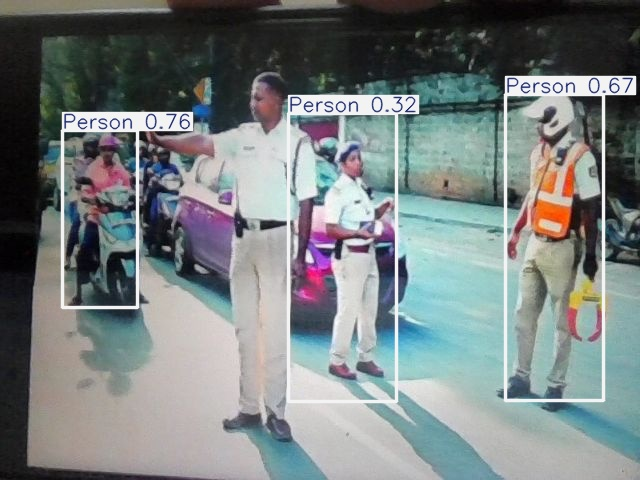

In [ ]:
from ultralytics import YOLO

# Load YOLOv10 model (replace with your correct model path)
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Run inference on captured image
results = model("photo.jpg", save=True)

# Display detected objects
from IPython.display import Image
Image(filename="runs/detect/predict/photo.jpg")

# **Object Detection Implementation**

In [23]:
import cv2
from IPython.display import display, Image
from ultralytics import YOLO

# Load the YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

def detect_people_from_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading frame.")
            break

        # Run the YOLO model on the frame
        results = model(frame)

        # Extract detections and draw bounding boxes
        for result in results:
            for box in result.boxes.data:
                x1, y1, x2, y2, confidence, class_id = box.tolist()

                if int(class_id) == 2:  # '2' is the class ID for people
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    cv2.putText(frame, f"Person {confidence:.2f}", (int(x1), int(y1) - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display the frame in the notebook
        _, buffer = cv2.imencode('.jpg', frame)
        display(Image(data=buffer.tobytes()))

        # Add a short delay to simulate real-time playback
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object
    cap.release()

# Specify the path to the video file
video_path = "/content/abc.mp4"  # video file path

# Run the detection
detect_people_from_video(video_path)


Output hidden; open in https://colab.research.google.com to view.

# **Object Tracking Implementation using Kalman filters**

In [24]:
import cv2
import numpy as np
from IPython.display import display, Image
from ultralytics import YOLO

# Load the YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Kalman Filter class
class KalmanTracker:
    def __init__(self):
        self.kalman = cv2.KalmanFilter(4, 2)  # 4 state variables (x, y, dx, dy), 2 measurements (x, y)
        self.kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)  # Measurement matrix
        self.kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)  # Transition matrix
        self.kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03  # Process noise
        self.state = None
        self.measurement = np.array((2, 1), np.float32)  # Initial measurement

    def predict(self):
        return self.kalman.predict()

    def update(self, measurement):
        self.measurement = measurement
        self.kalman.correct(self.measurement)
        return self.kalman.statePost

def detect_and_track_people_from_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    trackers = []

    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading frame.")
            break

        # Run the YOLO model on the frame
        results = model(frame)

        # Extract detections and create Kalman filters for each detected person
        detections = []
        for result in results:
            for box in result.boxes.data:
                x1, y1, x2, y2, confidence, class_id = box.tolist()

                if int(class_id) == 2:  #'2' is the class ID for people
                    detections.append([x1, y1, x2, y2, confidence])

        # If no existing trackers, create new Kalman filters
        if not trackers and detections:
            for detection in detections:
                tracker = KalmanTracker()
                center_x = (detection[0] + detection[2]) / 2
                center_y = (detection[1] + detection[3]) / 2
                tracker.update(np.array([center_x, center_y], np.float32))
                trackers.append(tracker)

        # Update each Kalman filter and draw tracks
        for tracker in trackers:
            prediction = tracker.predict()
            predicted_x, predicted_y = int(prediction[0]), int(prediction[1])

            # Draw the predicted location
            cv2.circle(frame, (predicted_x, predicted_y), 5, (0, 255, 0), -1)

            # Update Kalman filter with the actual detection position (if available)
            for detection in detections:
                center_x = (detection[0] + detection[2]) / 2
                center_y = (detection[1] + detection[3]) / 2
                tracker.update(np.array([center_x, center_y], np.float32))

                # Draw bounding box for the tracked object
                cv2.rectangle(frame, (int(detection[0]), int(detection[1])), (int(detection[2]), int(detection[3])), (0, 255, 0), 2)
                cv2.putText(frame, f"Person {confidence:.2f}", (int(detection[0]), int(detection[1]) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display the frame in the notebook
        _, buffer = cv2.imencode('.jpg', frame)
        display(Image(data=buffer.tobytes()))

        # Add a short delay to simulate real-time playback
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object
    cap.release()

# Specify the path to the video file
video_path = "/content/abc.mp4"  #  video file path

# Run the detection and tracking
detect_and_track_people_from_video(video_path)


Output hidden; open in https://colab.research.google.com to view.

# **Evaluation** **and** **Metrics**

In [25]:
import cv2
import numpy as np
import time
from ultralytics import YOLO

# Load YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Dummy ground truth for testing (replace with your actual data)
ground_truth_boxes = [
    (100, 150, 200, 250),  # Example ground truth bounding box
    (300, 100, 400, 200)
]

# IoU Calculation
def compute_iou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

# Evaluate detection accuracy (Precision, Recall, IoU)
def evaluate_detection_accuracy(detected_boxes, ground_truth_boxes):
    iou_scores = []
    true_positive = 0
    false_positive = 0
    false_negative = 0

    if not detected_boxes:
        print("No detections found.")
        return 0, 0, []

    for detected_box in detected_boxes:
        best_iou = 0
        best_match = None
        for gt_box in ground_truth_boxes:
            iou = compute_iou(detected_box, gt_box)
            iou_scores.append(iou)  # Collect IoU scores for mean calculation
            if iou > best_iou:
                best_iou = iou
                best_match = gt_box

        # If the IoU is greater than 0.3 (original threshold), it's considered a match
        if best_iou > 0.3:
            true_positive += 1
            ground_truth_boxes.remove(best_match)  # Remove matched ground truth
        else:
            false_positive += 1

    # False negatives are unmatched ground truth boxes
    false_negative = len(ground_truth_boxes)

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    return precision, recall, iou_scores

# Evaluate computational efficiency (FPS and latency)
def evaluate_performance(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    total_frames = 0
    total_time = 0  # Time to process the video frames
    all_detected_boxes = []  # To store all detected bounding boxes
    ground_truth_boxes_copy = ground_truth_boxes.copy()  # Copy ground truth for reuse

    while True:
        start_time = time.time()

        ret, frame = cap.read()
        if not ret:
            break

        total_frames += 1

        # Run the YOLO model on the frame
        results = model(frame)

        # Extract the bounding boxes (detected people) for evaluation
        detected_boxes = []
        for result in results:
            for box in result.boxes.data:
                x1, y1, x2, y2, confidence, class_id = box.tolist()
                if int(class_id) == 2:  # '2' is the class ID for people
                    detected_boxes.append([x1, y1, x2, y2])

        # Store detected boxes for accuracy evaluation after processing all frames
        all_detected_boxes.extend(detected_boxes)

        total_time += time.time() - start_time

    # Evaluate detection accuracy after processing all frames
    precision, recall, iou_scores = evaluate_detection_accuracy(all_detected_boxes, ground_truth_boxes_copy)

    # Calculate FPS and latency
    fps = total_frames / total_time if total_time > 0 else 0
    avg_latency = total_time / total_frames if total_frames > 0 else 0

    # Print final results
    print(f"Evaluation Completed")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Mean IoU: {np.mean(iou_scores) if iou_scores else 0:.4f}")
    print(f"FPS: {fps:.2f}")
    print(f"Average Latency: {avg_latency:.4f} seconds")

    cap.release()

# Example video path
video_path = "/content/abc.mp4"  # video file path

# Run the evaluation
evaluate_performance(video_path)



0: 384x640 1 Person, 13.4ms
Speed: 1.8ms preprocess, 13.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 10.0ms
Speed: 1.6ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Person, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 

In [40]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
